In [1]:
using Pkg
Pkg.precompile()
Pkg.activate("..")
Pkg.instantiate()

  Activating project at `~/awid/automaticDifferentiation/ADLib`


In [2]:
using JLD2
X_train = load("./imdb_dataset_prepared.jld2", "X_train")
y_train = load("./imdb_dataset_prepared.jld2", "y_train")
X_test = load("./imdb_dataset_prepared.jld2", "X_test")
y_test = load("./imdb_dataset_prepared.jld2", "y_test")
embeddings = load("./imdb_dataset_prepared.jld2", "embeddings")
vocab = load("./imdb_dataset_prepared.jld2", "vocab")
nothing

embedding_dim = size(embeddings,1);

In [3]:
using Random, ADLib

Random.seed!(0)
batch_size=128
dataset = ADLib.DataLoader((X_train, y_train), batchsize=batch_size, shuffle=true)
nothing

dtype = Float32

modelA = ADLib.Sequence(
    ADLib.Embedding{dtype}(length(vocab), embedding_dim),
    ADLib.Recurrent{dtype}(ADLib.ReLU(), embedding_dim, 16),
    ADLib.SelectLast{dtype}(),
    ADLib.Dense{dtype}(ADLib.Identity(), 16, 1)
)
modelA.layers[1].weights .= embeddings;
opt = ADLib.RMSProp(lr = 0.001)
history = ADLib.train(modelA, opt, dataset, X_test, y_test, ADLib.binary_crossentropy_logits, ADLib.binary_accuracy,
    ADLib.binary_crossentropy_logits_gradient, epochs=12)

Epoch: 1/12 (11.01s) 	Train: (loss: 0.70, acc: 0.51) 	val: (loss: 0.69, acc: 0.50) (allocations: 10.62 GiB, 11.3% gc, 31.2% compilation)
Epoch: 2/12 (6.12s) 	Train: (loss: 0.69, acc: 0.52) 	val: (loss: 0.69, acc: 0.51) (allocations: 10.17 GiB, 13.8% gc, 0.0% compilation)
Epoch: 3/12 (5.26s) 	Train: (loss: 0.68, acc: 0.53) 	val: (loss: 0.69, acc: 0.51) (allocations: 10.17 GiB, 15.2% gc, 0.0% compilation)
Epoch: 4/12 (5.44s) 	Train: (loss: 0.65, acc: 0.62) 	val: (loss: 0.64, acc: 0.65) (allocations: 10.17 GiB, 14.1% gc, 0.0% compilation)
Epoch: 5/12 (4.28s) 	Train: (loss: 0.57, acc: 0.73) 	val: (loss: 0.65, acc: 0.66) (allocations: 10.17 GiB, 17.2% gc, 0.0% compilation)
Epoch: 6/12 (4.50s) 	Train: (loss: 0.52, acc: 0.77) 	val: (loss: 0.57, acc: 0.73) (allocations: 10.17 GiB, 16.8% gc, 0.0% compilation)
Epoch: 7/12 (4.38s) 	Train: (loss: 0.46, acc: 0.81) 	val: (loss: 0.49, acc: 0.79) (allocations: 10.17 GiB, 17.1% gc, 0.0% compilation)
Epoch: 8/12 (4.36s) 	Train: (loss: 0.41, acc: 0.84) 	

Dict{String, Vector{Float32}} with 6 entries:
  "train_loss"    => [0.698325, 0.689508, 0.684296, 0.646667, 0.573423, 0.51806…
  "train_acc"     => [0.514003, 0.523937, 0.531225, 0.616938, 0.727761, 0.77266…
  "time"          => [11.0093, 6.12424, 5.26136, 5.44211, 4.27618, 4.49755, 4.3…
  "val_loss"      => [0.694248, 0.693577, 0.691352, 0.644511, 0.647795, 0.56840…
  "val_acc"       => [0.5021, 0.507, 0.5134, 0.6511, 0.6598, 0.7267, 0.7892, 0.…
  "total_samples" => [313.0, 313.0, 313.0, 313.0, 313.0, 313.0, 313.0, 313.0, 3…

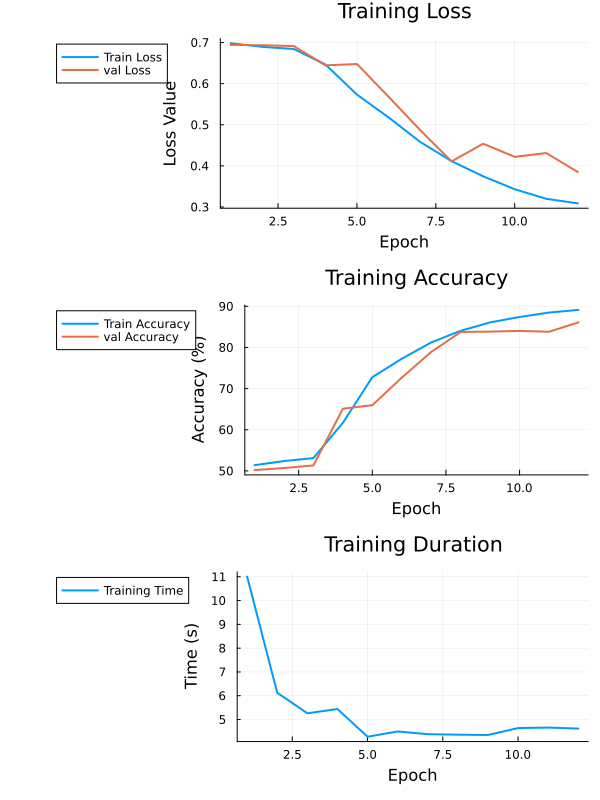

In [4]:
ADLib.plot_training_history(history)

In [5]:
using Flux, Random
Random.seed!(0)

model = Chain(
    Flux.Embedding(length(vocab), embedding_dim),
    Flux.RNN(embedding_dim => 16, relu, return_state = true),
    x -> x[end],
    Flux.flatten,
    Dense(16, 1, σ)
)


Chain(
  Embedding(12849 => 50),               # 642_450 parameters
  RNN(50 => 16, relu),                  # 1_072 parameters
  var"#1#2"(),
  Flux.flatten,
  Dense(16 => 1, σ),                    # 17 parameters
)                   # Total: 6 arrays, 643_539 parameters, 2.455 MiB.

In [6]:
# add Glove embeddings to Embedding layer
model.layers[1].weight .= embeddings;

In [7]:
using Printf, Statistics, Flux

history2 = Dict{String, Vector{dtype}}(
        "train_loss" => dtype[],
        "train_acc" => dtype[],
        "val_loss" => dtype[],
        "val_acc" => dtype[],
        "time" => dtype[],
        "total_samples" => Int[]
    )

dataset = Flux.DataLoader((X_train, y_train), batchsize=128, shuffle=true)

loss(m, x, y) = Flux.Losses.binarycrossentropy(m(x), y)
accuracy(m, x, y) = mean((m(x) .> 0.5) .== (y .> 0.5))

opt = Optimisers.setup(RMSProp(), model)

epochs = 12
for epoch in 1:epochs
    total_loss = 0.0
    total_acc = 0.0
    num_samples = 0

    stats = @timed begin
        for (x, y) in dataset
            Flux.reset!(model)
            grads = Flux.gradient(model) do m
                loss(m, x, y)
            end
            Optimisers.update!(opt, model, grads[1])
            total_loss += loss(model, x, y)
            total_acc += accuracy(model, x, y)
            num_samples += 1
        end

        train_loss = total_loss / num_samples
        train_acc = total_acc / num_samples
        test_acc = accuracy(model, X_test, y_test)
        test_loss = loss(model, X_test, y_test)
    end

    gc_pct = 100 * stats.gctime / stats.time
    compile_pct = 100 * (stats.compile_time / stats.time)
    push!(history2["train_loss"], train_loss)
    push!(history2["train_acc"], train_acc)
    push!(history2["val_loss"], test_loss)
    push!(history2["val_acc"], test_acc)
    push!(history2["total_samples"], num_samples)
    push!(history2["time"], stats.time)
    
    println(@sprintf("Epoch: %d (%.2fs) \tTrain: (l: %.2f, a: %.2f) \tTest: (l: %.2f, a: %.2f) (allocations: %.2f GiB, %.1f%% gc, %.1f%% compilation)", 
        epoch, stats.time, train_loss, train_acc, test_loss, test_acc, stats.bytes/1e9, gc_pct, compile_pct))
end

Epoch: 1 (28.32s) 	Train: (l: 0.69, a: 0.52) 	Test: (l: 0.69, a: 0.50) (allocations: 16.22 GiB, 5.1% gc, 66.9% compilation)
Epoch: 2 (10.88s) 	Train: (l: 0.68, a: 0.54) 	Test: (l: 0.69, a: 0.51) (allocations: 13.80 GiB, 15.9% gc, 0.0% compilation)
Epoch: 3 (9.76s) 	Train: (l: 0.58, a: 0.70) 	Test: (l: 0.53, a: 0.75) (allocations: 13.80 GiB, 13.3% gc, 0.0% compilation)
Epoch: 4 (8.37s) 	Train: (l: 0.47, a: 0.79) 	Test: (l: 0.53, a: 0.79) (allocations: 13.80 GiB, 14.4% gc, 0.0% compilation)
Epoch: 5 (8.57s) 	Train: (l: 0.41, a: 0.83) 	Test: (l: 0.44, a: 0.82) (allocations: 13.80 GiB, 15.8% gc, 0.0% compilation)
Epoch: 6 (9.54s) 	Train: (l: 0.37, a: 0.85) 	Test: (l: 0.39, a: 0.84) (allocations: 13.80 GiB, 14.5% gc, 0.0% compilation)
Epoch: 7 (8.97s) 	Train: (l: 0.33, a: 0.87) 	Test: (l: 0.45, a: 0.83) (allocations: 13.80 GiB, 14.1% gc, 0.0% compilation)
Epoch: 8 (8.50s) 	Train: (l: 0.31, a: 0.88) 	Test: (l: 0.39, a: 0.84) (allocations: 13.80 GiB, 14.4% gc, 0.0% compilation)
Epoch: 9 (8.75

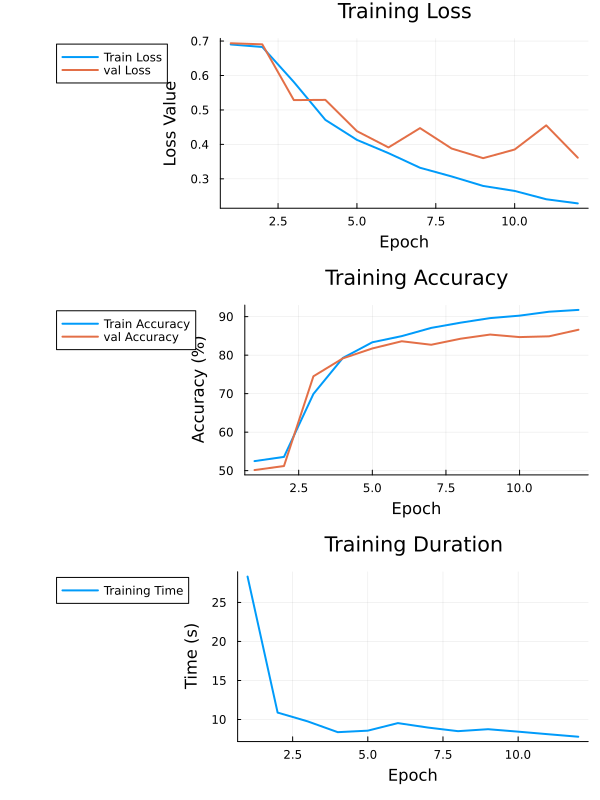

In [8]:
ADLib.plot_training_history(history2)

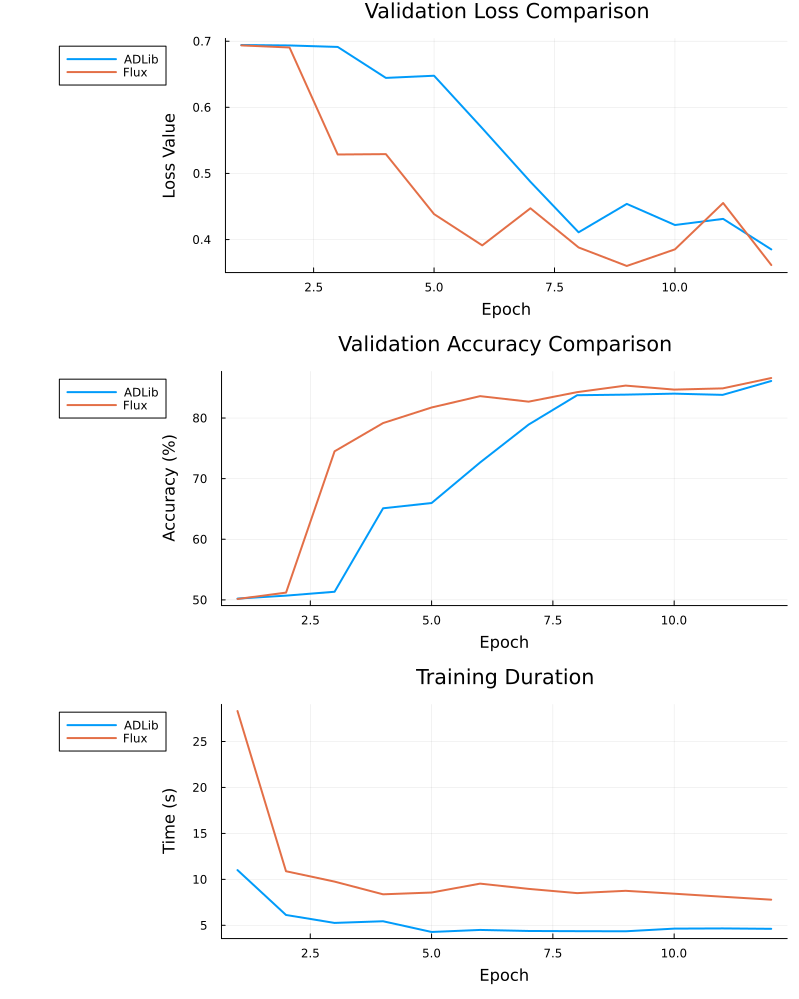

In [9]:
using Plots
p1 = plot(history["val_loss"], label="ADLib", linewidth=2)
plot!(history2["val_loss"], label="Flux", linewidth=2)
title!(p1, "Loss")
xlabel!(p1, "Epoch")
ylabel!(p1, "Loss Value")
title!("Validation Loss Comparison")

p2 = plot(history["val_acc"].*100, label="ADLib", linewidth=2)
plot!(history2["val_acc"].*100, label="Flux", linewidth=2)
title!(p2, "Accuracy")
xlabel!(p2, "Epoch")
ylabel!(p2, "Accuracy (%)")
title!("Validation Accuracy Comparison")

p3 = plot(history["time"], label="ADLib", linewidth=2)
plot!(history2["time"], label="Flux", linewidth=2)
title!(p3, "Time")
xlabel!(p3, "Epoch")
ylabel!(p3, "Time (s)")
title!("Training Duration")

plot(p1, p2, p3, layout=(3,1), size=(800,1000), legend=:outertopleft)

In [10]:
println(history["val_acc"])
println(history2["val_acc"])

Float32[0.5021, 0.507, 0.5134, 0.6511, 0.6598, 0.7267, 0.7892, 0.8376, 0.8386, 0.8402, 0.8382, 0.8611]
Float32[0.5015, 0.512, 0.7451, 0.7917, 0.8174, 0.8361, 0.827, 0.8427, 0.8535, 0.8469, 0.8489, 0.866]


In [17]:
const target_accuracy = 0.85
const num_trials = 10
const max_epochs = 100

results = Dict{String, Vector{Float64}}(
    "epochs_needed" => [],
    "total_times" => [],
    "final_accuracies" => []
)

for trial in 1:num_trials
    Random.seed!(trial)
    
    model = Chain(
        Flux.Embedding(length(vocab), embedding_dim),
        Flux.RNN(embedding_dim => 16, relu, return_state=true),
        x -> x[end],
        Flux.flatten,
        Dense(16, 1, σ)
    )
    model.layers[1].weight .= embeddings
    opt = Optimisers.setup(RMSProp(), model)
    
    epoch_count = 0
    trial_time = 0.0
    best_acc = 0.0
    
    println("\nStarting trial $trial with seed $trial")
    
    while best_acc < target_accuracy && epoch_count < max_epochs
        epoch_count += 1
        
        stats = @timed begin
            total_loss = 0.0
            total_acc = 0.0
            num_batches = 0
            
            for (x, y) in dataset
                Flux.reset!(model)
                grads = Flux.gradient(model) do m
                    loss(m, x, y)
                end
                Optimisers.update!(opt, model, grads[1])
                total_loss += loss(model, x, y)
                total_acc += accuracy(model, x, y)
                num_batches += 1
            end
            
            train_loss = total_loss / num_batches
            train_acc = total_acc / num_batches
            test_acc = accuracy(model, X_test, y_test)
            test_loss = loss(model, X_test, y_test)
        end
        
        trial_time += stats.time
        best_acc = max(best_acc, test_acc)
        
        println(@sprintf("Epoch %d: val_acc=%.3f, time=%.2fs", 
                        epoch_count, test_acc, stats.time))
        
        if test_acc >= target_accuracy
            println("Target accuracy reached at epoch $epoch_count")
            break
        end
    end
    
    push!(results["epochs_needed"], epoch_count)
    push!(results["total_times"], trial_time)
    push!(results["final_accuracies"], best_acc)
end

avg_epochs = mean(results["epochs_needed"])
std_epochs = std(results["epochs_needed"])
avg_time = mean(results["total_times"])
std_time = std(results["total_times"])
avg_acc = mean(results["final_accuracies"])

println("\nFinal Results (10 trials)")
println("Average epochs needed: $(round(avg_epochs, digits=1)) ± $(round(std_epochs, digits=1))")
println("Average training time: $(round(avg_time, digits=1))s ± $(round(std_time, digits=1))s")
println("Average final accuracy: $(round(avg_acc, digits=1))%")
println("\nPer-trial details:")
for i in 1:num_trials
    println("Trial $i: $(results["epochs_needed"][i]) epochs, $(round(results["total_times"][i], digits=1))s, $(round(results["final_accuracies"][i], digits=1))%")
end


Starting trial 1 with seed 1
Epoch 1: val_acc=0.566, time=10.93s
Epoch 2: val_acc=0.741, time=9.79s
Epoch 3: val_acc=0.755, time=10.00s
Epoch 4: val_acc=0.822, time=9.79s
Epoch 5: val_acc=0.836, time=9.68s
Epoch 6: val_acc=0.845, time=9.85s
Epoch 7: val_acc=0.850, time=9.90s
Epoch 8: val_acc=0.852, time=9.75s
Target accuracy reached at epoch 8

Starting trial 2 with seed 2
Epoch 1: val_acc=0.576, time=10.31s
Epoch 2: val_acc=0.777, time=9.94s
Epoch 3: val_acc=0.811, time=8.81s
Epoch 4: val_acc=0.835, time=7.85s
Epoch 5: val_acc=0.847, time=8.28s
Epoch 6: val_acc=0.852, time=8.24s
Target accuracy reached at epoch 6

Starting trial 3 with seed 3
Epoch 1: val_acc=0.736, time=8.21s
Epoch 2: val_acc=0.762, time=8.10s
Epoch 3: val_acc=0.817, time=8.37s
Epoch 4: val_acc=0.827, time=7.85s
Epoch 5: val_acc=0.822, time=8.08s
Epoch 6: val_acc=0.800, time=7.79s
Epoch 7: val_acc=0.839, time=8.10s
Epoch 8: val_acc=0.840, time=7.76s
Epoch 9: val_acc=0.813, time=7.90s
Epoch 10: val_acc=0.810, time=8.

In [18]:
const target_accuracy = 0.85
const num_trials = 10
const max_epochs = 100

results2 = Dict{String, Vector{Float64}}(
    "epochs_needed" => [],
    "total_times" => [],
    "final_accuracies" => []
)

X_val = X_test
y_val = y_test
loss_function = ADLib.binary_crossentropy_logits
accuracy_function = ADLib.binary_accuracy
gradient_function = ADLib.binary_crossentropy_logits_gradient

for trial in 1:num_trials
    Random.seed!(trial)
    
    model = ADLib.Sequence(
        ADLib.Embedding{Float32}(length(vocab), embedding_dim),
        ADLib.Recurrent{Float32}(ADLib.ReLU(), embedding_dim, 16),
        ADLib.SelectLast{Float32}(),
        ADLib.Dense{Float32}(ADLib.Identity(), 16, 1)
    )
    model.layers[1].weights .= embeddings
    optimizer = ADLib.RMSProp(lr=0.001)
    
    epoch_count = 0
    trial_time = 0.0
    best_acc = 0.0
    
    println("\nStarting trial $trial with seed $trial")
    
    while best_acc < target_accuracy && epoch_count < max_epochs
        epoch_count += 1
        
        epoch_loss = 0.0
        epoch_accuracy = 0.0
        epoch_samples = 0
        
        stats = @timed begin
            for (x, y) in dataset
                current_batch_size = size(x, 3)
                ADLib.reset!(model, size(x, 2), current_batch_size)
                output = model(x)

                batch_loss = loss_function(y, output)
                batch_accuracy = accuracy_function(y, output)
                
                epoch_loss += batch_loss * current_batch_size
                epoch_accuracy += batch_accuracy * current_batch_size
                epoch_samples += current_batch_size
                
                gradient = gradient_function(y, output)
                gradient ./= current_batch_size
                ADLib.backward_pass(model, gradient)
                ADLib.update_weights(model, optimizer)
            end
            
            train_loss = epoch_loss / epoch_samples
            train_acc = epoch_accuracy / epoch_samples
            
            val_output = model(X_val)
            val_loss = loss_function(y_val, val_output)
            val_acc = accuracy_function(y_val, val_output)
        end
        
        trial_time += stats.time
        best_acc = max(best_acc, val_acc)
        
        println(@sprintf("Epoch %d: val_acc=%.3f, time=%.2fs", 
                        epoch_count, val_acc, stats.time))
        
        if val_acc >= target_accuracy
            println("Target accuracy reached at epoch $epoch_count")
            break
        end
    end
    
    push!(results2["epochs_needed"], epoch_count)
    push!(results2["total_times"], trial_time)
    push!(results2["final_accuracies"], best_acc)
end

avg_epochs = mean(results2["epochs_needed"])
std_epochs = std(results2["epochs_needed"])
avg_time = mean(results2["total_times"])
std_time = std(results2["total_times"])
avg_acc = mean(results2["final_accuracies"])

println("\nFinal Results ($num_trials trials)")
println("---------------------------------")
println("Average epochs needed: $(round(avg_epochs, digits=1)) ± $(round(std_epochs, digits=1))")
println("Average training time: $(round(avg_time, digits=1))s ± $(round(std_time, digits=1))s")
println("Average final accuracy: $(round(avg_acc, digits=2))")
println("\nPer-trial details:")
for i in 1:num_trials
    println("Trial $i: $(results2["epochs_needed"][i]) epochs, ",
            "$(round(results2["total_times"][i], digits=1))s, ",
            "$(round(results2["final_accuracies"][i], digits=2))")
end


Starting trial 1 with seed 1
Epoch 1: val_acc=0.502, time=8.78s
Epoch 2: val_acc=0.507, time=8.93s
Epoch 3: val_acc=0.508, time=9.01s
Epoch 4: val_acc=0.509, time=6.77s
Epoch 5: val_acc=0.511, time=5.76s
Epoch 6: val_acc=0.698, time=5.39s
Epoch 7: val_acc=0.773, time=5.05s
Epoch 8: val_acc=0.752, time=4.96s
Epoch 9: val_acc=0.827, time=4.81s
Epoch 10: val_acc=0.831, time=4.87s
Epoch 11: val_acc=0.789, time=4.91s
Epoch 12: val_acc=0.854, time=5.00s
Target accuracy reached at epoch 12

Starting trial 2 with seed 2
Epoch 1: val_acc=0.503, time=7.12s
Epoch 2: val_acc=0.506, time=7.14s
Epoch 3: val_acc=0.509, time=6.18s
Epoch 4: val_acc=0.525, time=5.92s
Epoch 5: val_acc=0.740, time=5.20s
Epoch 6: val_acc=0.730, time=5.06s
Epoch 7: val_acc=0.785, time=5.14s
Epoch 8: val_acc=0.772, time=5.19s
Epoch 9: val_acc=0.821, time=5.02s
Epoch 10: val_acc=0.817, time=5.04s
Epoch 11: val_acc=0.830, time=5.01s
Epoch 12: val_acc=0.838, time=5.01s
Epoch 13: val_acc=0.818, time=4.89s
Epoch 14: val_acc=0.84

In [22]:
println("\nPer-trial Fluxdetails:")
for i in 1:num_trials
    println("Trial $i: $(results["epochs_needed"][i]) epochs, $(round(results["total_times"][i]/results["epochs_needed"][i], digits=1))s, $(round(results["final_accuracies"][i], digits=2))")
end


Per-trial Fluxdetails:
Trial 1: 8.0 epochs, 10.0s, 0.85
Trial 2: 6.0 epochs, 8.9s, 0.85
Trial 3: 18.0 epochs, 7.9s, 0.85
Trial 4: 100.0 epochs, 8.0s, 0.84
Trial 5: 13.0 epochs, 8.0s, 0.85
Trial 6: 15.0 epochs, 7.9s, 0.85
Trial 7: 15.0 epochs, 7.8s, 0.85
Trial 8: 100.0 epochs, 8.2s, 0.65
Trial 9: 7.0 epochs, 9.3s, 0.86
Trial 10: 100.0 epochs, 8.4s, 0.56


In [23]:
println("\nPer-trial ADLib details:")
for i in 1:num_trials
    println("Trial $i: $(results2["epochs_needed"][i]) epochs, ",
            "$(round(results2["total_times"][i]/results2["epochs_needed"][i], digits=1))s, ",
            "$(round(results2["final_accuracies"][i], digits=2))")
end


Per-trial ADLib details:
Trial 1: 12.0 epochs, 6.2s, 0.85
Trial 2: 36.0 epochs, 5.1s, 0.85
Trial 3: 41.0 epochs, 5.1s, 0.85
Trial 4: 14.0 epochs, 5.1s, 0.86
Trial 5: 48.0 epochs, 5.2s, 0.85
Trial 6: 6.0 epochs, 5.0s, 0.85
Trial 7: 7.0 epochs, 5.8s, 0.86
Trial 8: 7.0 epochs, 5.8s, 0.85
Trial 9: 11.0 epochs, 5.7s, 0.85
Trial 10: 18.0 epochs, 5.1s, 0.85
